In [1]:
import re
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import json

%load_ext rpy2.ipython

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Functions</h3>
<p>
First we create a function that takes a list of file names from the corpus as an argument, 
read texts, removes punctuation and split texts into lines


In [2]:
def load_data(files):
    '''
    files:  list of file names from src/corpus directory
    '''

    texts = dict()

    # Iterate over files        
    for file in files:     
        
        # Get text name without .txt (and remove a b (c) from Christ and Guthlac)
        text_name = re.sub('\.txt', '', file)
        text_name = re.sub(' a b( c)?', '', text_name)
    
        # Read file
        with open(os.path.join('src', 'corpus', file)) as f:
            x = f.read() 

        # Remove initial and final hashtag
        x = re.sub('^ *#|# *$', '', x)

        # Remove punctuation
        x = re.sub('[\.\,\;\@\!\"\?\'\:\(\)\-\—]', ' ', x)

        # Remove double spaces
        x = re.sub('  +', ' ', x)

        # Add blankspace to the beginning and end of each line
        # if not already there (this is to treat line-initial 
        # ngrams and line-final ngrams same way as other word-initial
        # and word-final ngrams, i.e. preceded|followed by blankspace
        x = re.sub(r'([^ ])#', r'\1 #', x)
        x = re.sub(r'#([^ ])', r'# \1', x)
        x = re.sub(r'^([^ ])', r' \1', x)
        x = re.sub(r'([^ ])$', r'\1 ', x)

        texts[text_name] = x.split('#')

    return texts

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's check whether all the punctuation have been removed by printing out all the characters found in all the texts in a corpus.

In [3]:
texts = load_data(os.listdir(os.path.join('src', 'corpus')))
chars = set()

for text_name in texts:
    for line in texts[text_name]:
        for char in line:
            chars.add(char)

print(chars)

{'s', 'e', 'c', 't', 'v', 'z', 'ᛟ', 'q', 'x', 'b', 'a', 'k', 'æ', 'l', 'r', 'n', 'þ', 'g', 'i', 'p', ' ', 'm', 'o', 'd', 'h', 'ð', 'u', 'y', 'w', 'f'}


<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's also check some text to be sure.

In [4]:
print(texts['guthlac'])

[' se bið gefeana fægrast þonne hy æt frymðe gemetað ', ' engel ond seo eadge sawl ofgiefeþ hio þas eorþan wynne ', ' forlæteð þas lænan dreamas ond hio wiþ þam lice gedæleð ', ' ðonne cwið se engel hafað yldran had ', ' greteð gæst oþerne abeodeð him godes ærende ', ' nu þu most feran þider þu fundadest ', ' longe ond gelome ic þec lædan sceal ', ' wegas þe sindon weþe ond wuldres leoht ', ' torht ontyned eart nu tidfara ', ' to þam halgan ham þær næfre hreow cymeð ', ' edergong fore yrmþum ac þær biþ engla dream ', ' sib ond gesælignes ond sawla ræst ', ' ond þær a to feore gefeon motun ', ' dryman mid dryhten þa þe his domas her ', ' æfnað on eorþan he him ece lean ', ' healdeð on heofonum þær se hyhsta ', ' ealra cyninga cyning ceastrum wealdeð ', ' ðæt sind þa getimbru þe no tydriað ', ' ne þam fore yrmþum þe þær in wuniað ', ' lif aspringeð ac him bið lenge hu sel ', ' geoguþe brucað ond godes miltsa ', ' þider soðfæstra sawla motun ', ' cuman æfter cwealme þa þe her cristes æ ',

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Now we define function to calculate frequencies of ngrams

In [5]:
def ngram_frequencies(texts, n=3):
    '''
    texts:    {dict} of texts 
    n:        ngram length
    '''

    frequencies = defaultdict(lambda: defaultdict(int))
    
    for text_name in texts:
        for line in texts[text_name]:
            for j in range(0, len(line)-n):
                ngram = line[j:j+n]
                frequencies[text_name][ngram] += 1

    # Transform dict to pandas dataframe
    df = pd.DataFrame.from_dict(frequencies, orient='index').fillna(0)

    # Transform absolute frequencies to relative frequencies   
    # TODO: isn't this step unecessary since we're using cosine metric?
    df = df.div(df.sum(axis=1), axis=0)
    
    return df

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
And a function to plot dendrogram

In [6]:
def clustering(df, metric='cosine', method='complete', mft=None):
    '''
    df:      dataframe produced by ngram_frequencies()
    metric:  metric by which distance will be calculated, for list of options see link below
    method:  linkage criterion that will be used, for list of options see link below
    mft:     number of most frequent types (ngrams) to analyze, if mft=None: analyze all ngrams

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    '''
    
    # If number of [m]ost [f]requent [t]ypes specified: 
    # slice the dataframe
    if mft:
        sums = df.sum(numeric_only=True).sort_values(ascending=False)[0:mft]
        df = df[sums.keys()]
                
    # Create linkage matrix
    linkage_matrix = linkage(df, method=method, metric=metric)
        
    # Plot dendrogram
    palette = ("r", "g", "b", "m", "k", "Olive", "SaddleBrown", "CadetBlue", "DarkGreen", "Brown")
    (leaves, colors) = (list(), dict())
    
    text_names = set()
    for sample in list(df.index):
        text_name = re.sub(' \(.*$', '', sample)
        text_names.add(text_name)
    text_names = list(text_names)

    for sample in list(df.index):    
        leaves.append(sample)
        text_name = re.sub(' \(.*$', '', sample)
        colors[sample] = palette[text_names.index(text_name) % 10]
        
    plt.ioff()
    fig = plt.figure(figsize=(16, int(len(leaves)/5)+5))
    ddata = dendrogram(linkage_matrix, color_threshold=0.00001,
                       labels=leaves, orientation='right',
                       leaf_font_size=14)
    ax = plt.gca()
    xlbls = ax.get_ymajorticklabels()
    for lbl in xlbls:
        lbl.set_color(colors[lbl.get_text()])                
    plt.show()
    plt.close(fig)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's just try to plot a dendrogram for some of the longest texts in the corpus
<ul><li>We have Elene and Andreas clustered together complying with Cynewulfian authorship hypothesis, but otherwise the dendrogram doesn't say much.</li></ul>

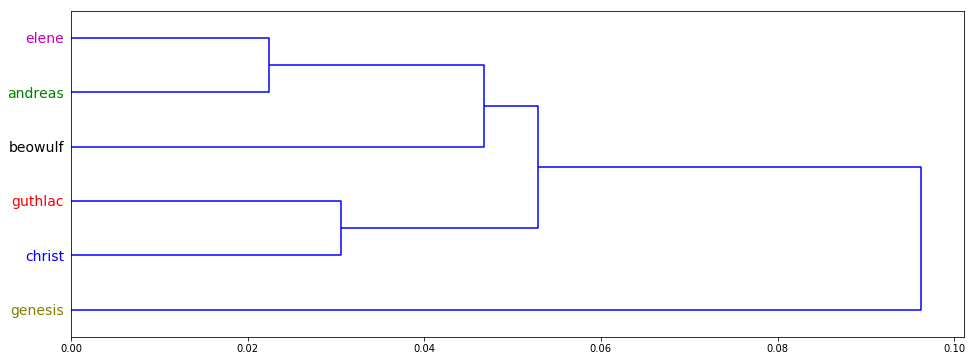

In [10]:
texts = load_data(['beowulf.txt', 'genesis.txt', 'andreas.txt', 'christ a b c.txt', 
                   'guthlac a b.txt', 'andreas.txt', 'elene.txt'])
df = ngram_frequencies(texts)
clustering(df, mft=500)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
To get more interesting results, we define a function to split texts into samples of n lines.
<p>
For further use we also allow samples to overlap (when n > step).
<p>
To make dendrograms easier to read we also define a function that assign additional labels. For texts traditionally separated into parts (e.g. Genesis A, B) we mark each sample with letter(s) indicating from which part it comes from and number indicating how many lines from a given part there are in the sample.

In [11]:
def sampling(texts, n=300, step=300):
    '''
    texts:  {dict} of texts 
    n:      number of lines in one sample
    step:   after how many lines new sample should start (set step = n to get non-overlapping samples)
    '''
    
    samples = defaultdict(list)
    
    # Iterate over texts
    for text_name in texts:

        # Restart samples indexing for each new text
        sample_indices = [1]

        # Iterate over lines of text
        for i, line in enumerate(texts[text_name]):

            # Iterate over current sample indices
            for si in sample_indices:

                # Get label
                label = _sample_label(text_name, si, n, step)

                # Add line to sample
                if label:
                    samples['{0} ({1}) {2}'.format(text_name, str(si).zfill(2), label)].append(line)
                else:
                    samples['{0} ({1})'.format(text_name, str(si).zfill(2))].append(line)
                    
            # Add new sample index if step was reached  
            if i % step == 0 and i > 1 and len(texts[text_name]) >= i + n - 1:
                sample_indices.append( sample_indices[-1] + 1 )

            # Remove first sample index if it reached the size
            if i >= n and (i - n) % step == 0:
                sample_indices = sample_indices[1:]
                
    return samples

def sampling(texts, n=300, step=300):
    '''
    texts:  {dict} of texts 
    n:      number of lines in one sample
    step:   after how many lines new sample should start (set step = n to get non-overlapping samples)
    '''
    
    samples = defaultdict(list)
    
    # Iterate over texts
    for text_name in texts:

        # Restart samples indexing for each new text
        sample_indices = [1]

        # Iterate over lines of text
        for i, line in enumerate(texts[text_name]):

            # Iterate over current sample indices
            for si in sample_indices:

                # Get label
                label = _sample_label(text_name, si, n, step)

                # Add line to sample
                if label:
                    samples['{0} ({1}) {2}'.format(text_name, str(si).zfill(2), label)].append(line)
                else:
                    samples['{0} ({1})'.format(text_name, str(si).zfill(2))].append(line)                
                    
            # Add new sample index if step was reached  
            if (i+1) % step == 0 and i > 1 and len(texts[text_name]) > i + n:
                sample_indices.append( sample_indices[-1] + 1 )

            # Remove first sample index if it reached the size
            if (i+1) >= n and (i - n + 1) % step == 0:
                sample_indices = sample_indices[1:]
                
    return samples


In [12]:
def _sample_label(text_name, sample_index, n, step):
    '''
    text_name:     name of the text from which the sample comes
    sample_index:  index of the sample
    n:             number of lines in one sample
    step:          after how many lines new sample should start
    '''
        
    # Get number of the first and the last line in sample
    first_line = (sample_index-1) * step + 1
    last_line = first_line + n - 1
    
    # Define partitions of poems
    # note: range() does not include endpoint, so it has to be set to the line after the end of the passage
    partitions = {
        'beowulf': {
            'A': range(1,2301),
            'B': range(2301,3183),
        },
        'genesis': {
            'A': list(range(1,235)) + list(range(852,2937)),
            'B': range(235,852),
        },
        'christ': {
            'A': range(1,440),
            'B': range(440,867),
            'C': range(867, 1665),
        },
        'guthlac': {
            'A': range(1,819),
            'B': range(819,1380),
        },
    }
    
    # Return None if the text is not one of those enumerated above
    if text_name not in partitions:
        return None
    
    # Count the lines belonging to each partition and create a label
    counts = defaultdict(int)
    for i in range(first_line, last_line + 1):
        for p in partitions[text_name]:
            if i in partitions[text_name][p]:
                counts[p] += 1
                
    label = list()
    for p in sorted(counts):
        label.append('{0}{1}'.format(p, counts[p]))
                     
    label = '/'.join(label)
    return label.translate(str.maketrans('0123456789', '₀₁₂₃₄₅₆₇₈₉'))
        
        
    

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Clustering</h3>
<p>
We start with non-overlapping samples of 300 lines and clustering based on 500 most frequent 3-grams.
<ul><li>
    The result is nice and clear:
    <ul>
        <li>Samples from each texts end clustered together with only one exception: sample 1 of Elene which is not linked to other samples from Elene directly, but later to Elene-Andreas cluster. If we accept the hypothesis that both poems are by Cynewulf, this actually makes sense.</li>
        <li>For Christ we have A and A/B samples clustered separately from B/C and C samples</li>
        <li>For Guthlac we have A and A/B (but dominantly A) samples clustered separately from B sample</li>
        <li>For Genesis we have A samples clustered separately from A/B and B samples</li>
        <li>For Beowulf there is a big gap between A and A/B + B samples!</li>
        
    </ul> 
</li></ul>


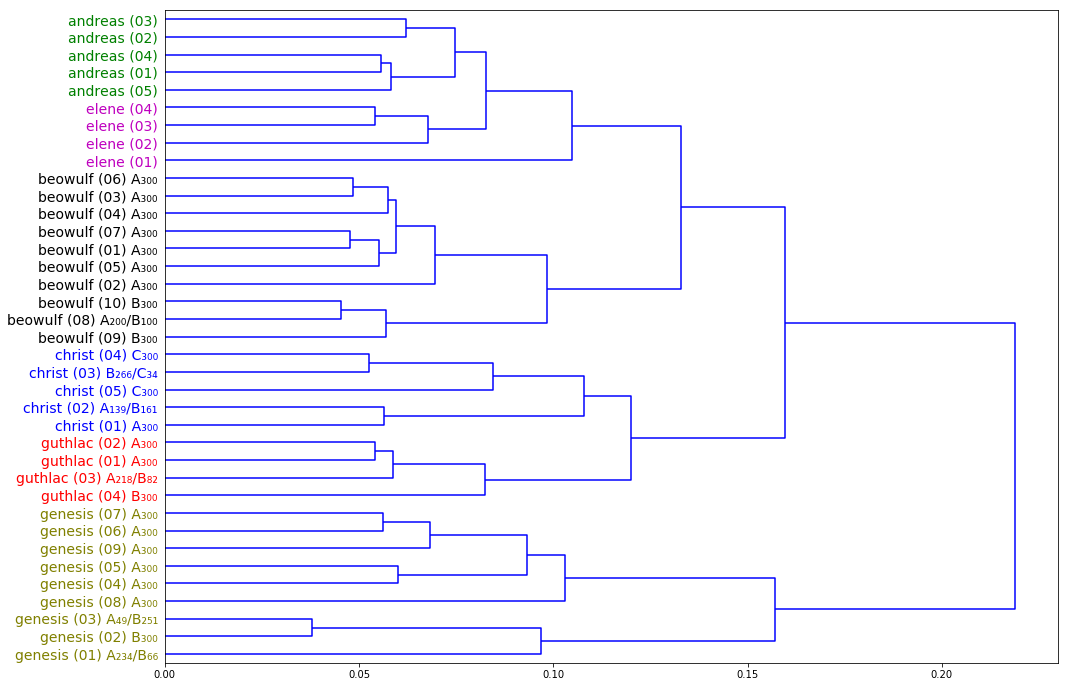

In [13]:
texts = load_data(['beowulf.txt', 'genesis.txt', 'andreas.txt', 'christ a b c.txt', 
                   'guthlac a b.txt', 'andreas.txt', 'elene.txt'])
samples = sampling(texts, n=300, step=300)
df = ngram_frequencies(samples, n=3)
clustering(df, mft=500)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Now compare it to the result we obtain when only 25 most frequent 3-grams are employed (the number used in the article).
<ul><li>It's very poor when compared to the one above</ul></li>

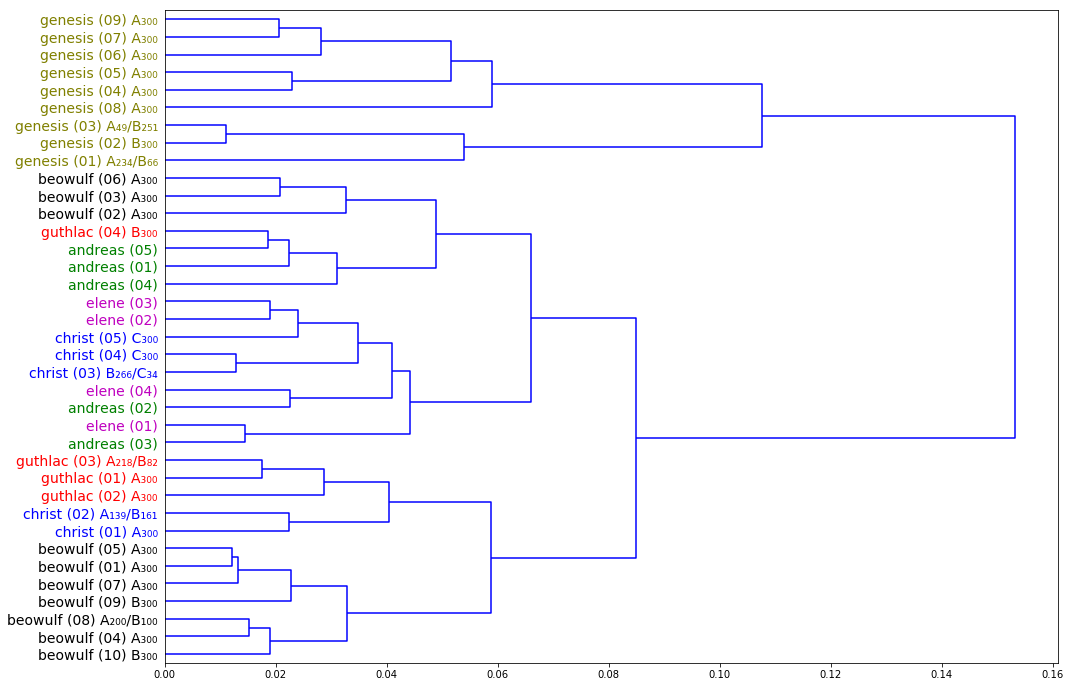

In [14]:
clustering(df, mft=25)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
In the first dendrogram we have samples very unmatched with traditional partitioning of the texts. As we don't want to reduce the sample size to low, we lower the step to 100, obtaining thus overlapping samples.
<ul><li>
    The result seems very good:
    <ul>
        <li>Samples from each texts end clustered together with exception of initial samples of Elene being clustered with Andreas once again (cf. possible Cynewulfian authorship of both)</li>
        <li>For Christ we have (A + A/B with dominance of A) samples clustered separately from (B + A/B with dominance of B or with A and B being balanced). Then there is a big gap between these and (C + B/C clusters)</li>
        <li>For Guthlac we have (A + A/B with dominance of A) samples clustered separately from (B + A/B with dominance of B)</li>
        <li>For Genesis we have a pretty clear divisions between A, A/B, and B</li>
        <li>For Beowulf there is a big gap between two clusters (actually bigger than for Guthlac A,B or Christ A,B). This does not seem to support the division to 1:2299 | 2300:end but rather the division by scribal hand change (line 1939, cf. Neidorf et al.: p. 3)</li>
    </ul>
    
</ul></li>

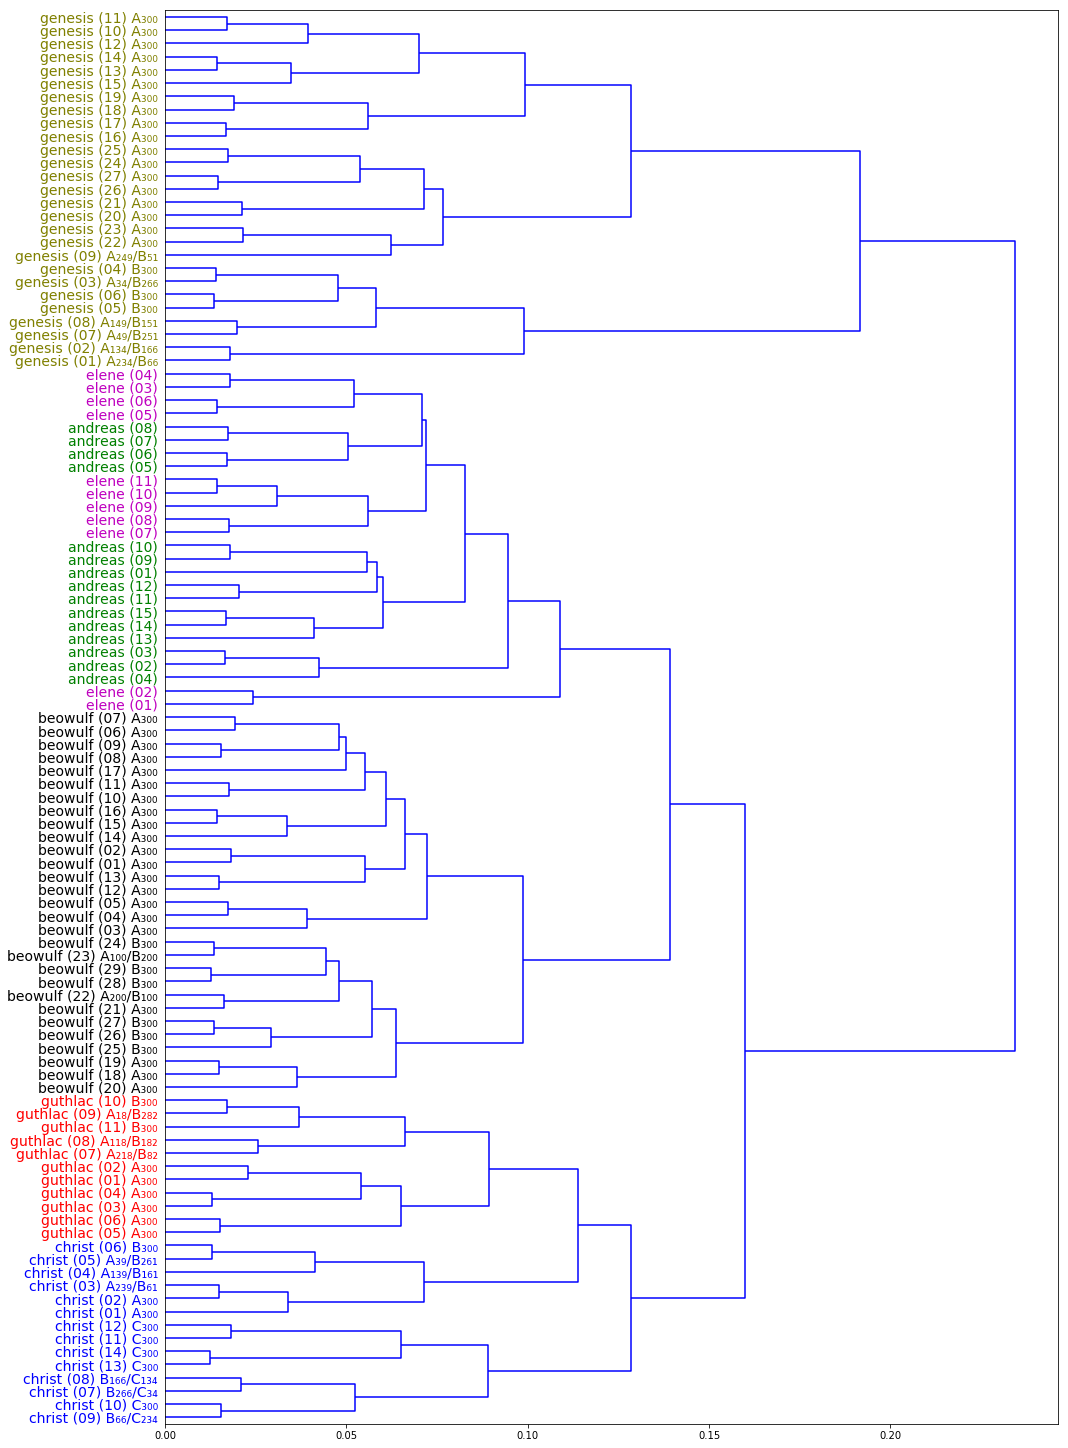

In [15]:
samples = sampling(texts, step=100)
df = ngram_frequencies(samples, n=3)
clustering(df, mft=500)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
With 500 most frequent 4-grams the result is very similar (not messing Elene and Andreas any more)

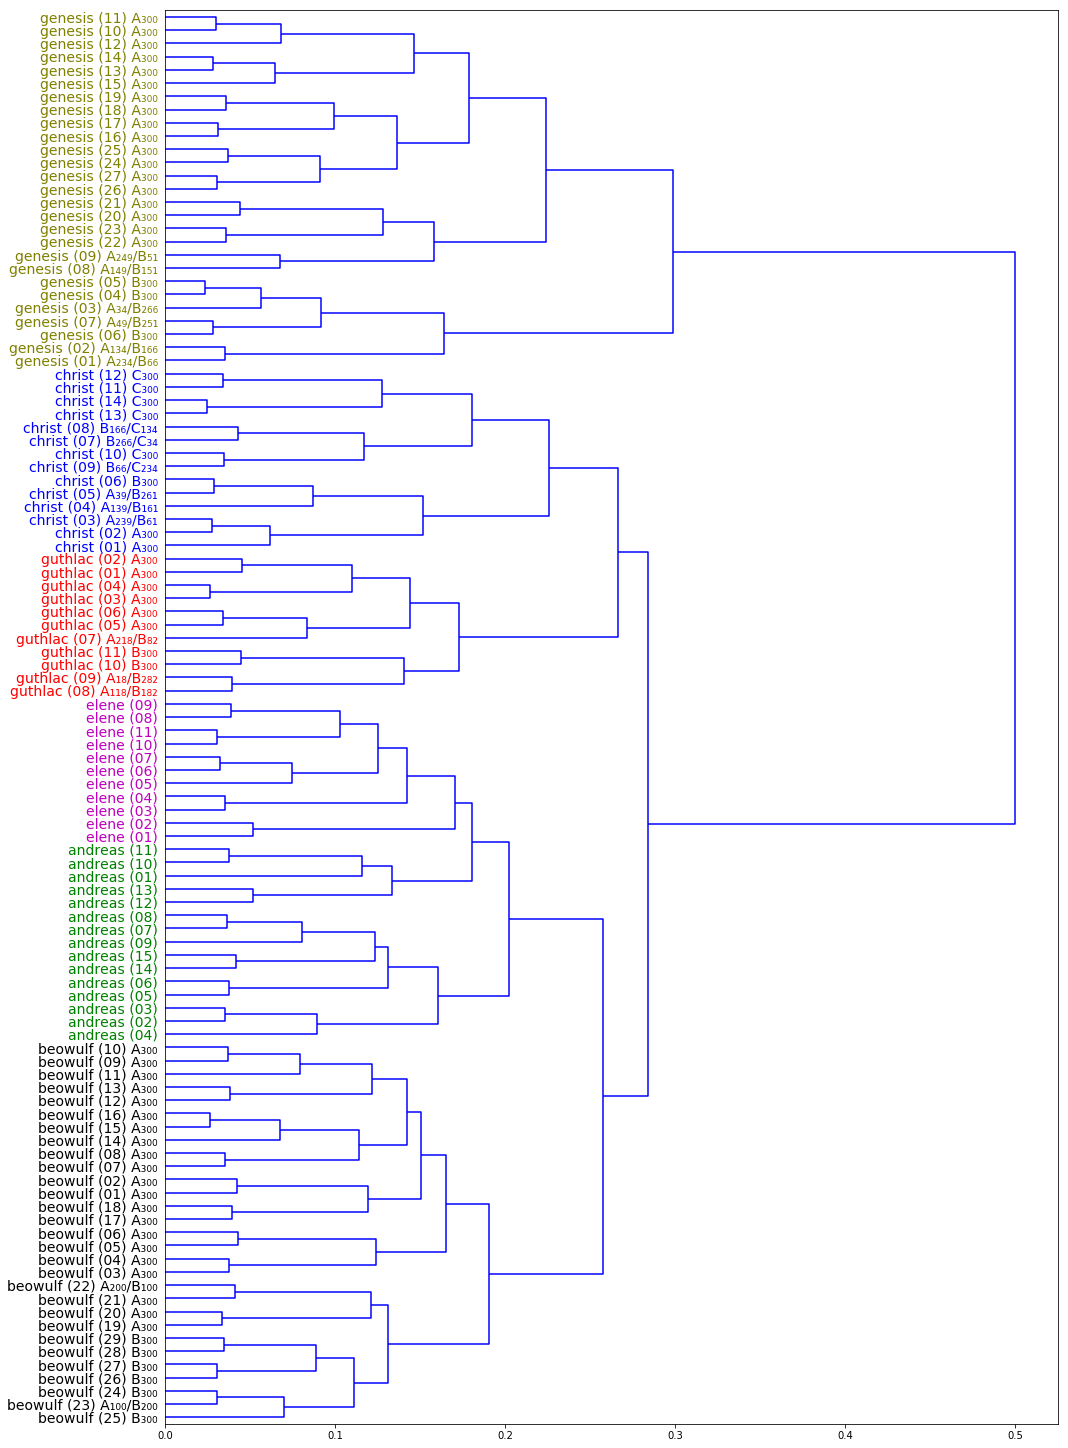

In [16]:
df = ngram_frequencies(samples, n=4)
clustering(df, mft=500)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
With 500 most frequent 2-grams (almost all the 2-grams found in the texts) the result is not that good, but still gives a clear division of Beowulf.

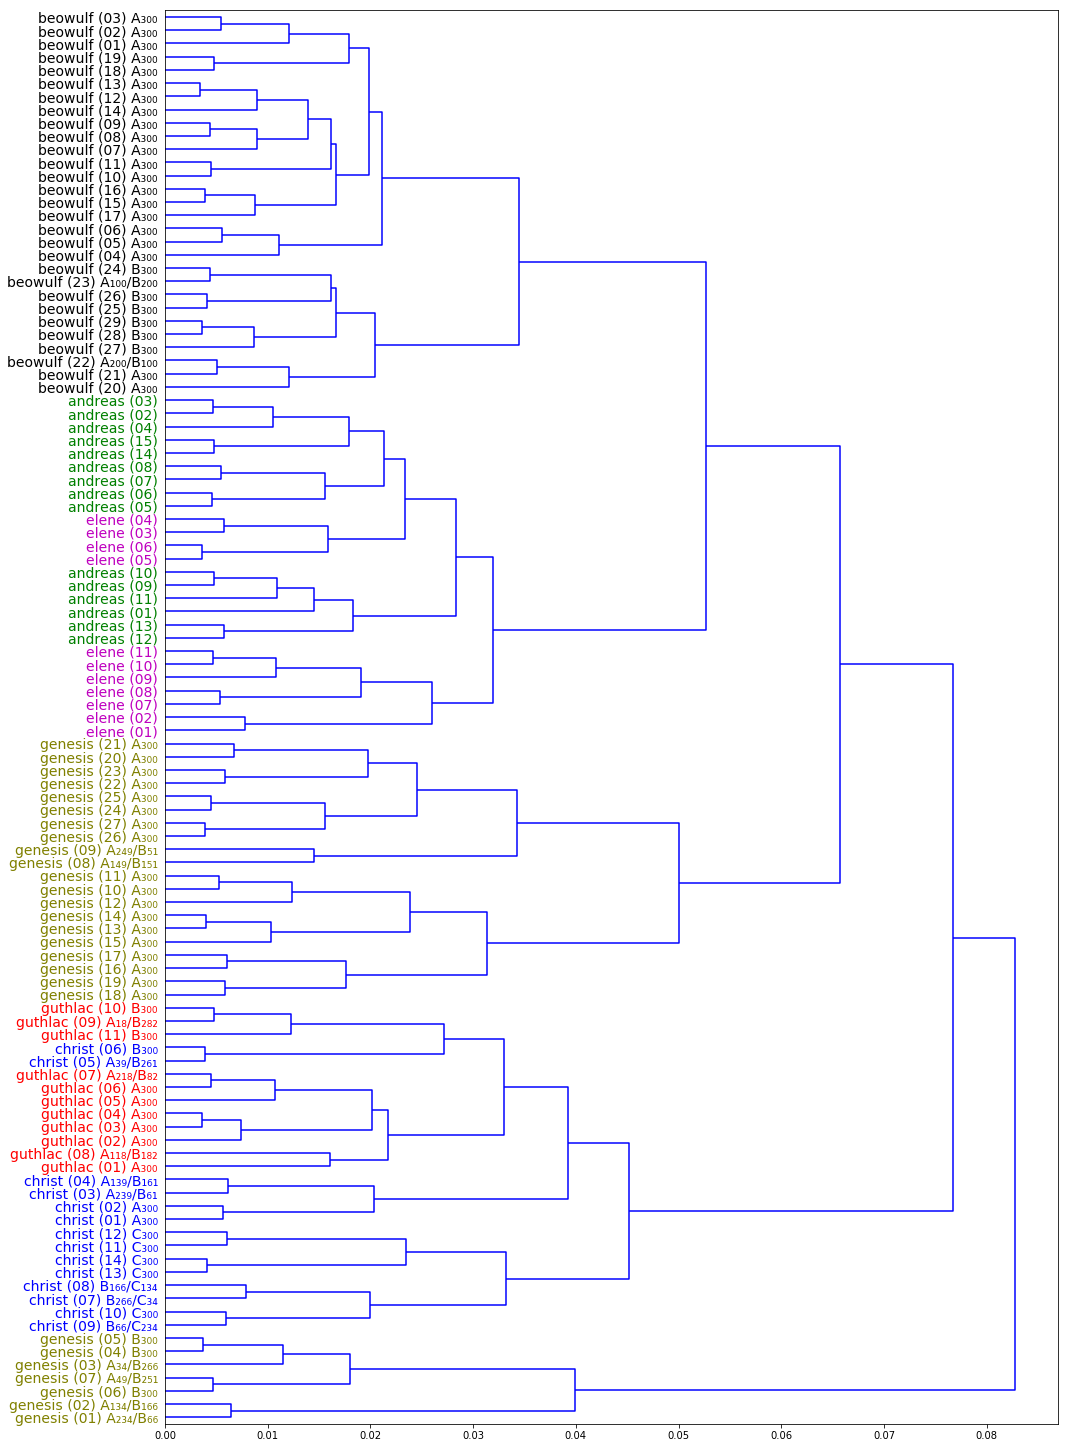

In [17]:
df = ngram_frequencies(samples, n=2)
clustering(df, mft=500)

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Comparing clusterization of Beowulf over different n-gram lengths and MFT settings</h3>

In order to be sure we are not just cherry-picking the results that correspond to our hyothesis, we perform a battery of cluster analyses of Beowulf with different n-gram lengths and different MFT settings. As we are not really interested in the bottom nodes (it does not matter whether sample 2 clusters with sample 1 or sample 3), we focus only the very top node - we will check to which of the two cluster particular samples are assigned in each iteration.

<ul><li>
The result shows that the partition of Beowulf is very stable across different features and MFTs. It only tends to differ with the lowest values of MFT.       
</li><ul>


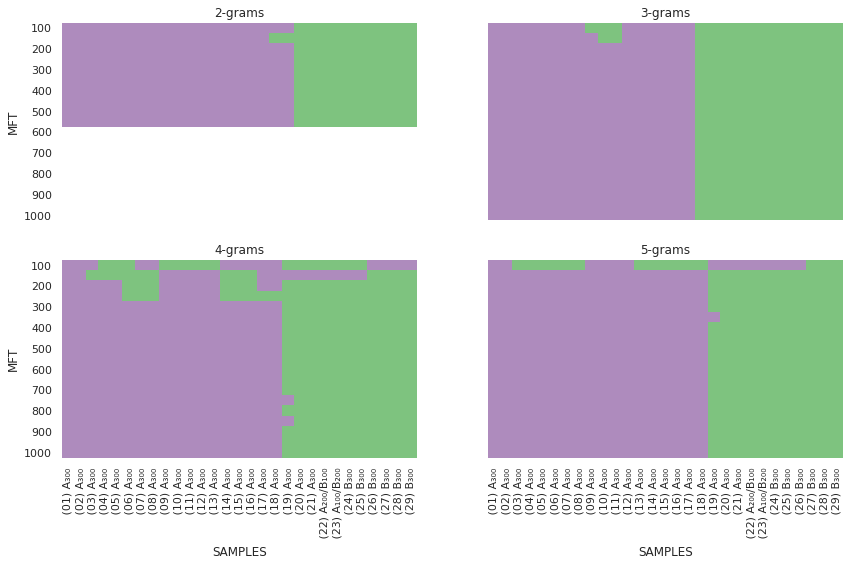

In [18]:
import seaborn as sns; sns.set()

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['legend.fontsize'] = 20
fig = plt.figure()
plti = 1

# Iterate over values of n(-grams)
for n in (2, 3, 4, 5):

    clusters = list()

    # Count frequencies of n-grams in samples
    df = ngram_frequencies(samples, n=n)

    # Keep only data for Beowulf
    df = df[df.index.str.startswith('beo')]

    # Iterate over various levels of [m]ost [f]requent [t]ypes
    for mft in [ i*50 for i in range(2,21) ]:
        
        # Slice the dataframe to keep only the specified number of mft
        sums = df.sum(numeric_only=True).sort_values(ascending=False)[0:mft]
        df_ = df[sums.keys()]

        # Perform agglomerative clustering with number of clusters limited to 2 
        cluster = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
        clu = cluster.fit_predict(df_)

        # We end up with list of ones and zeros indicating to which cluster the sample belongs
        # We want to assure that the labels correspond accross samples, so if the very first 
        # sample is labeled as 1 instead of 0, we reverse the values
        if clu[0] == 1:
            clu = abs(clu - 1)
            
        # Append the result to list of clusterizations
        clusters.append(clu)
        
    # Convert list of clusterization into data frame 
    index = [ i*50 for i in range(2,21) ]
    hm = pd.DataFrame(clusters, index=index, columns = df.index.str.replace('beowulf', ''))     

    # Create subplot
    plt.subplot(2, 2, plti)

    # Plot 2-grams
    if n == 2:
        # Get rid of values for n > 550 (This is the entire vocabulary of 2-grams, so after this value we are 
        # just repeating the last experiment)
        hm.iloc[10:] = np.nan
        # Plot the subplot without x-axis labels
        ax = sns.heatmap(hm, annot=False, cmap='PRGn', cbar=False, vmin=-0.5, vmax=1.5, 
                         xticklabels=False)
        # We want the area where data are missing to be white
        ax.set_facecolor('#FFFFFF')
        ax.set_ylabel('MFT')

    # Plot 3-grams
    elif n == 3:
        ax = sns.heatmap(hm, annot=False, cmap='PRGn', cbar=False, vmin=-0.5, vmax=1.5,
                         xticklabels=False, yticklabels=False)
    # Plot 4-grams
    elif n == 4:
        ax = sns.heatmap(hm, annot=False, cmap='PRGn', cbar=False, vmin=-0.5, vmax=1.5)
        ax.set_xlabel('SAMPLES')
        ax.set_ylabel('MFT')

    # Plot 5-grams
    else:
        ax = sns.heatmap(hm, annot=False, cmap='PRGn', cbar=False, vmin=-0.5, vmax=1.5, 
                         yticklabels=False)
        ax.set_xlabel('SAMPLES')

    # Set subplot title
    ax.set_title(label='{0}-grams'.format(n))
    
    # Plot the subplot
    plt.plot()
    plti += 1

plt.show()        


<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Create distance matrices for 100, 150, 200, ..., 2000 most frequent 2-, 3-, 4-, & 5-grams and plot the consensus trees.

In [19]:
def dist_matrix(df, metric='cosine', method='complete', mft=None):
    '''
    df:      dataframe produced by ngram_frequencies()
    metric:  metric by which distance will be calculated, for list of options see link below
    mft:     number of most frequent types (ngrams) to analyze, if mft=None: analyze all ngrams

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    '''
    
    # If number of [m]ost [f]requent [t]ypes specified: 
    # slice the dataframe
    if mft:
        sums = df.sum(numeric_only=True).sort_values(ascending=False)[0:mft]
        df = df[sums.keys()]
                
    # Create distance matrix
    similarity_matrix = cosine_similarity(df)
    sim_to_dist = np.vectorize(lambda i: round(1-i, 10))
    distance_matrix = sim_to_dist(similarity_matrix)
    distance_matrix = pd.DataFrame(distance_matrix, index=df.index, columns=df.index).to_dict(orient='index')
    return distance_matrix

output = defaultdict(dict)

# Iterate over values of n(-grams)
for n in (2, 3, 4, 5):

     # Count frequencies of n-grams in samples
    df = ngram_frequencies(samples, n=n)

    # Iterate over various levels of [m]ost [f]requent [t]ypes
    for mft in [ i*50 for i in range(2,21) ]:
        
        # Skip mft to large for 2-grams
        if n == 2 and mft > 550:
            continue
        
        # Get distance matrix
        output[n][mft] = dist_matrix(df, mft=mft)

with open('dist_matrices.json', 'w') as outfile:
    json.dump(output, outfile)

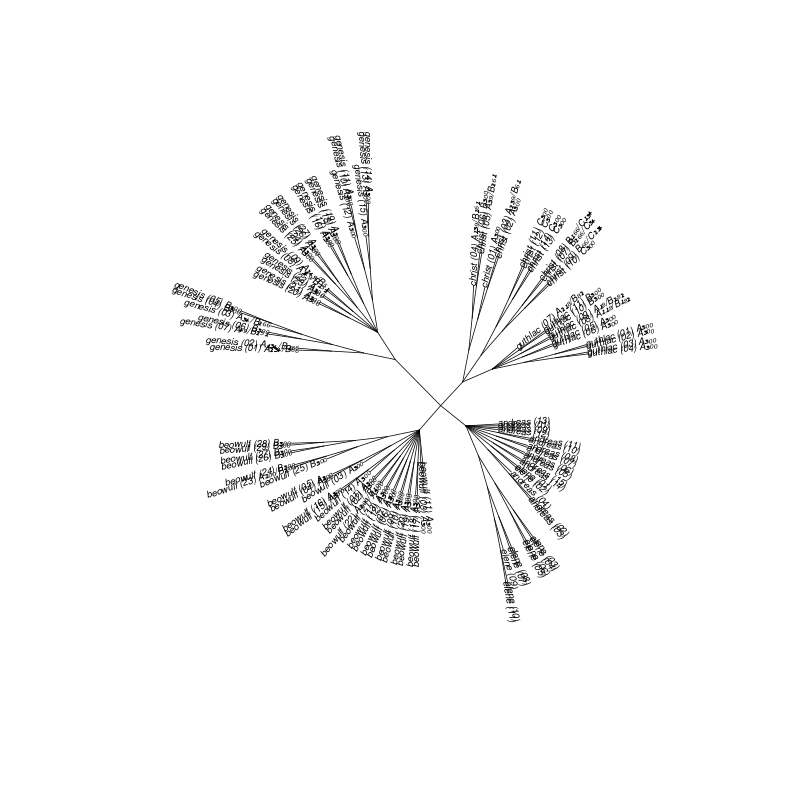

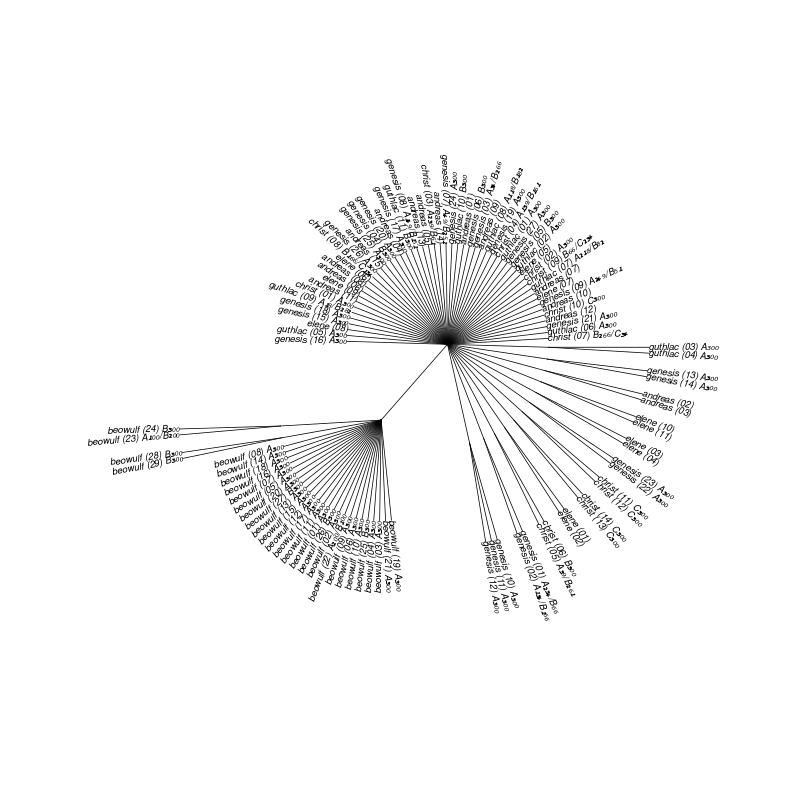

In [34]:
%%R -w 800 -h 800

library(tidyverse)
library(ape)
library(jsonlite)
library(phylogram)
library(ggdendro)


## load .json data
distances = fromJSON("dist_matrices.json")

# check the total number of distance tables and build an empty list
for_consensus =  vector('list', sum(sapply(distances, length)))

# counter for distance tables in process
n = 0

# for each ngram size & most-frequent features build distance table -> build hierarchical clustering for each table
for ( i in 1:length(distances)) {
  for (j in 1:length(distances[[i]])) {
    n = n + 1
    phylo = sapply(distances[[i]][[j]], cbind) # bind columns together
    rownames(phylo) = colnames(phylo) # row names as column names
    
    for_consensus[[n]] = as.dist(phylo) %>% # convert matrix "as distance" object
      hclust(method = "complete") %>% # hierarchical clustering
      as.phylo() # convert to phylogeny tree
    
  }
}

## build a majority-rule consensus tree
consensus = ape::consensus(for_consensus, p=0.5) # p = consensus strength

## convert back to dendrogram with "phylogram" package and perpare data for ggplot
ggtree = phylogram::as.dendrogram.phylo(consensus) %>%
  dendro_data()

## prepare labels
ggtree$labels = ggtree$labels %>%
  mutate(class = str_extract(label, "^(.*?) "),
         part = str_extract_all(label, "[:uppercase:]")) %>%
  unite(col = class, class:part, sep="") # unite titles & parts of texts in one column


# plot the tree
ggplot() + 
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=class), hjust=1.1, angle=0, size=3) + # map labels
  coord_flip() + 
  scale_y_continuous(expand=c(0.2, 0)) + 
  theme_dendro() +
  guides(color = FALSE) +
  labs(title="Majority-rule consensus tree (50% or more clades are identical in 67 trees)",
       subtitle = "Based on 2-grams (10 experiments) + 3-grams (19) + 4-grams (19) + 5-grams (19)\nDepth of most frequent features varying from 100 to 1000 in each ngram length, step 50")



### ALTERNATIVE UNROOTED RADIAL TREE
## in "stylo" package fashion (but no colors, colors are crazy in base plotting device)

consensus(for_consensus, p=0.5) %>% 
  plot(type="unrooted", lab4ut="axial", cex = 0.8)

## strict tree (100% agreement) reveals only three major clusters with 4 beowulf-B samples clearly branching (most similar to other B samples than anything else)  from beowulf-A

consensus(for_consensus, p=1) %>%
  plot(type="unrooted", lab4ut="axial", cex = 0.8)
